# Feed Forward Neural Network with Linear Algebra

In the former notebook we developed a simple FFN in pure python. Although it worked, it required a lot of code, and as you will see it was extremely slow. Luckily for us, almost all the operations needed for propagating the inputs through the neural network and updating the weights afterwards can be calculated efficiently using linear algebra. 

In this notebook we are going to use the scientific computing library Numpy to define the exact same network as we did before. We do this to show how much more compact the network can be formulated if we use concepts from linear algebra. 
When we afterwards use specialized deep learning frameworks do define the networks, it is important to remember that these are based on linear algebra as well, and are doing almost the same as we do here. 

The biggest difference is that they include advanced techniques for redundant operations and use the available hardware optimally.

## Dependencies and supporting functions
Load all dependancies and supporting functions by running the code block below.

In [1]:
%matplotlib inline
import sys, os
sys.path.append(os.path.join('.', '..')) # in order to import various .py files

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from intro_utils import *

from IPython.display import clear_output
from IPython import display

from sklearn.datasets import make_moons
from sklearn.metrics import precision_score, accuracy_score

## Define activation function and cost function

When doing classification with neural network we most often want the output to be a probability distribution over the available classes since this enable us to quantify how sure we are of a certain prediction. 

Whenever we use the softmax as an activation function in the final layer, we tend to use the cross entropy as our loss function. This is because the derivative of the cross entropy function works well with the derivative of the softmax function when doing backpropagation with a better preforming models as a result.

In [2]:
def softmax(values):
    exp_scores = np.exp(values)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

def cross_entropy(model, X, Y, regularization):
    hidden_weights, output_weights = model['HW'], model['OW']
    probs = predict(model, X, get_probs=True)
    
    num_examples = len(Y)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), Y])
    data_loss = np.sum(corect_logprobs)
    
    # Add regulatization term to loss (optional)
    data_loss += (regularization / 2) * (np.sum(np.square(hidden_weights)) + np.sum(np.square(output_weights)))
    
    return 1. / num_examples * data_loss

# Defining the model

The fully connected architecture we are trying to define can be visualized in the following manner: 

![alt text](images/ffn.png "Fully Connected Neural Net")

Each hidden unit $h_i$ in each layer is connected to all the units in the former layer. This means we can define a layer as matrix $M$ with its height being the amount of hidden units, and its rows being the amount of hidden units in the former layer. This matrix would then be the weights of this particular layer. However, we also want to to stabilize the function the network ends up approximating by adding a bias $b_i$ to each hidden unit $h_i$. Since each $h_i$ is a row in the matrix we simply add the bias $b_i$ to all elements in the row. Mathematically this equals the function: 

$$ Y = X * H + b $$

So in forward propagation we multiply each layer-matrix with its input and add a bias vector. We then apply an activation function to the result and pass the output of this activation function as the input to the next layer.

Backpropagation is a bit more tricky, and we will not go into detail with it here. However, simply put, backpropagation is a method of finding the derivatives of each weight in order to optimize the weight according to the loss function

In [3]:
def build_model(train_data, 
                test_data,
                input_dimensions = 2,
                hidden_dimensions = 3,
                output_dimensions = 2,
                epochs = 1000,
                learning_rate = 0.01,
                regularization = 0.01):
    
    X_train, Y_train = extract_data(train_data)
    X_test, Y_test = extract_data(test_data)
    
    # Define the necessary weights and biases
    # This time we normalize the random weights which is common practice (but done behind the scenes)
    hidden_weights = np.random.randn(input_dimensions, hidden_dimensions) / np.sqrt(input_dimensions)
    hidden_bias = np.zeros((1, hidden_dimensions)) # The bias is handled explicitly
    
    output_weights = np.random.randn(hidden_dimensions, output_dimensions) / np.sqrt(hidden_dimensions)
    output_bias = np.zeros((1, output_dimensions)) # The bias is handled explicitly
    
    model = { 
        "HW": hidden_weights,
        "Hb": hidden_bias,
        "OW": output_weights,
        "OB": output_bias
    }
    
    #   ------------- Code for plotting -------------
    xx_train, yy_train = mesh_grid(X_train)
    xx_test, yy_test = mesh_grid(X_test)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,8))
    ax1.scatter(X_train[:, 0], X_train[:, 1], s=60, cmap=plt.cm.coolwarm)
    ax2.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, s=60, cmap=plt.cm.coolwarm)
    
    #   ^^^^^^^^^^^^ End of plotting code ^^^^^^^^^^^^
    
    
    #  ------------- TRAINING THE MODEL -------------
    test_loss = []
    train_loss = []
    for i in range(1, epochs + 1):
        #  ------------- FORWARD PROPAGATION -------------
        hidden_values = X_train.dot(hidden_weights) + hidden_bias
        hidden_activations = np.tanh(hidden_values)
        output_values = hidden_activations.dot(output_weights) + output_bias
        probs = softmax(output_values)

        #  ------------- BACKPROPAGATION -------------
        output_delta = probs
        output_delta[range(len(X_train)), Y_train] -= 1
        output_weights_delta = (hidden_activations.T).dot(output_delta)
        output_bias_delta = np.sum(output_delta, axis=0, keepdims=True)
        
        # Here we take the derivative of Tanh and multiplies 
        hidden_delta = output_delta.dot(output_weights.T) * (1 - np.power(hidden_activations, 2))
        hidden_weights_delta = np.dot(X_train.T, hidden_delta)
        hidden_bias_delta = np.sum(hidden_delta, axis=0)

        #  ------------- ADD REGULARIZATION -------------
        
        # Add regularization terms (the biases don't have regularization terms)
        output_weights_delta += regularization * output_weights
        hidden_weights_delta += regularization * hidden_weights
        
        #  ------------- UPDATE WEIGHTS (Gradient Descent) -------------

        # Gradient descent parameter update
        output_weights += -learning_rate * output_weights_delta
        output_bias += -learning_rate * output_bias_delta
        
        hidden_weights += -learning_rate * hidden_weights_delta
        hidden_bias += -learning_rate * hidden_bias_delta
        
        model = { 
            "HW": hidden_weights,
            "HB": hidden_bias,
            "OW": output_weights,
            "OB": output_bias
        }
        
        #   ------------- Code for plotting -------------
        # Plot the current results
        if i % (epochs / 20) == 0:
            plot(model, ax1, X_train, Y_train, "Train", xx_train, yy_train)
            plot(model, ax2, X_test, Y_test, "Test", xx_test, yy_test)
            plot_error(ax3, train_loss, test_loss)
            display.clear_output(wait=True)
            display.display(plt.gcf())
        
        test_loss.append(cross_entropy(model, X_test, Y_test, regularization))
        train_loss.append(cross_entropy(model, X_train, Y_train, regularization))
        #   ^^^^^^^^^^^^ End of plotting code ^^^^^^^^^^^^

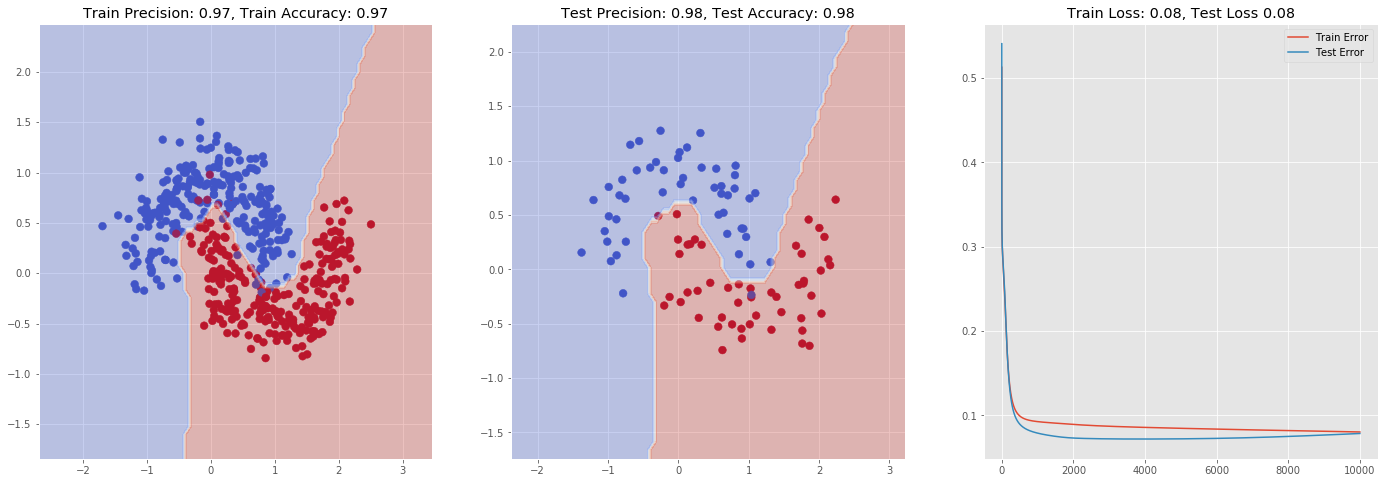

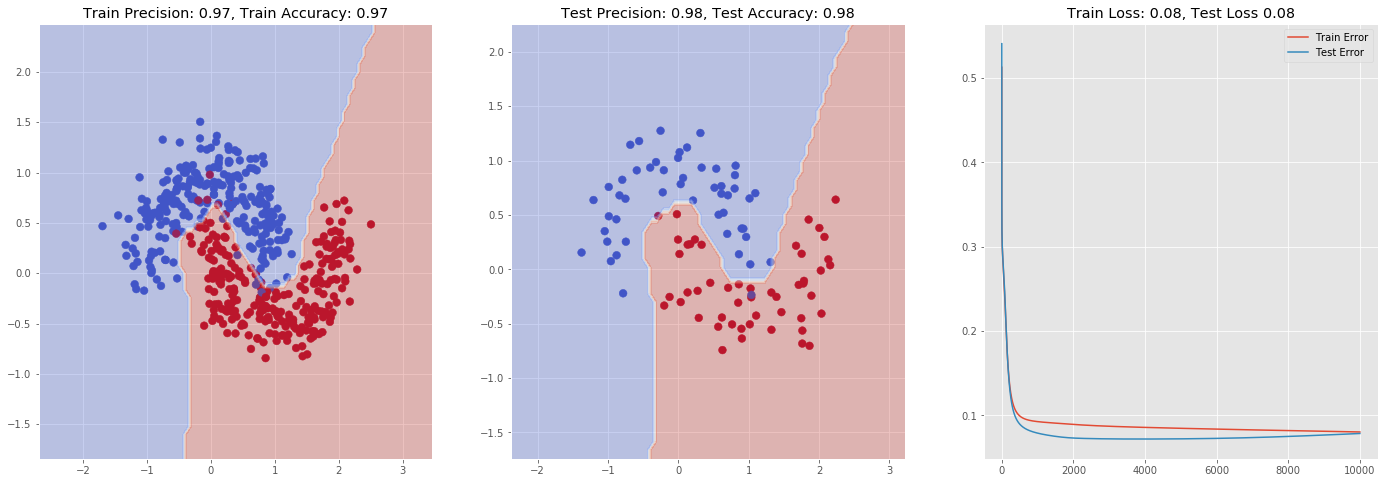

In [4]:
train_size = 500
test_size = 100

X_train, Y_train = make_moons(train_size, noise=0.2)
X_test, Y_test = make_moons(test_size, noise=0.2)


train_data = list(zip(X_train, Y_train))
test_data = list(zip(X_test, Y_test))

LEARNING_RATE = 0.001
REGULARIZATION = 0.01
HIDDEN_DIMENSIONS = 50
EPOCHS = 10000

build_model(train_data, 
            test_data, 
            epochs=EPOCHS,
            hidden_dimensions=HIDDEN_DIMENSIONS,
            regularization=REGULARIZATION,
            learning_rate=LEARNING_RATE)

# Assignments

 1) Add another layer to the network